In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord

from astropy.nddata import Cutout2D
import sys
import glob
import os
from astropy.table import *
from matplotlib.colors import LogNorm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
import matplotlib.mlab as mlab
import sys
import matplotlib.colors as colors
from astropy.table import vstack
from matplotlib.colors import LogNorm
from astropy.cosmology import z_at_value
from scipy import ndimage, misc


import matplotlib
from matplotlib.pyplot import *

from photutils.aperture import SkyCircularAperture
from photutils.aperture import aperture_photometry
from photutils.aperture import SkyCircularAnnulus
from photutils.utils import calc_total_error

import eazy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse
from astropy import stats
import grizli.catalog

import sep
from grizli import prep


from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

eazy.symlink_eazy_inputs()

/Users/vasily/miniconda3/envs/temp/lib/python3.9/site-packages/eazy/data/templates -> ./templates
/Users/vasily/miniconda3/envs/temp/lib/python3.9/site-packages/eazy/data/filters/FILTER.RES.latest -> ./FILTER.RES.latest


In [2]:
def prep_grz(root,flt,cut=False,psf_matched=False):
    
    if psf_matched:
        add_dir = 'psf_matched/'
        add = '_conv'
    else:
        add_dir = ''
        add = ''
        
    drz_im = fits.open(f'{add_dir}{root}-{flt}_sci{add}.fits')
    wht_im = fits.open(f'{add_dir}{root}-{flt}_wht{add}.fits')
    
    pixel_scale = np.abs(np.round(drz_im[0].header['CD1_1']*3600,decimals=3))
    
    print(f'Loaded {flt} image as {add_dir}{root}-{flt}_sci{add}.fits')
    print(f'Detected pixel scale of {pixel_scale}"/pix')
    
    wcs = WCS(drz_im[0].header)
    
    data = drz_im[0].data.byteswap().newbyteorder()
    wht = wht_im[0].data.byteswap().newbyteorder()

    err = 1/np.sqrt(wht)
    del(wht)

    mask = (~np.isfinite(err)) | (err == 0) | (~np.isfinite(data))
    err[mask] = 0

    data_mask = np.cast[data.dtype](mask)

    drz_im.close()
    wht_im.close()
    
    bkg_params={'bw': 64, 'bh': 64, 'fw': 3, 'fh': 3, 'pixel_scale': pixel_scale}

    bkg_input = {}
    if 'pixel_scale' in bkg_params:
        bkg_pscale = bkg_params['pixel_scale']
    else:
        print('Pixel scale not defined')

    for k in bkg_params:
        if k in ['pixel_scale']:
            continue
        if k in ['bw', 'bh']:
            bkg_input[k] = bkg_params[k]*bkg_pscale/pixel_scale
        else:
            bkg_input[k] = bkg_params[k]
    
    try:
        bkg = sep.Background(data, mask=mask, **bkg_input)
        bkg_data = bkg.back()
    except:
        print('Background Failed')
        bkg_data = np.zeros_like(data)

        
    
    return data,err,bkg_data,wcs,pixel_scale

  
def comp_background(data,err,pixel_scale):
    mask = (~np.isfinite(err)) | (err == 0) | (~np.isfinite(data))
    err[mask] = 0

    data_mask = np.cast[data.dtype](mask)

    bkg_params={'bw': 64, 'bh': 64, 'fw': 3, 'fh': 3, 'pixel_scale': pixel_scale}

    bkg_input = {}
    if 'pixel_scale' in bkg_params:
        bkg_pscale = bkg_params['pixel_scale']
    else:
        print('Pixel scale not defined')

    for k in bkg_params:
        if k in ['pixel_scale']:
            continue
        if k in ['bw', 'bh']:
            bkg_input[k] = bkg_params[k]*bkg_pscale/pixel_scale
        else:
            bkg_input[k] = bkg_params[k]
    
    try:
        data = data.copy(order='C')
        
        bkg = sep.Background(data, mask=mask, **bkg_input)
        bkg_data = bkg.back()
    except Exception as e:
        print(e)
        print('Background Failed')
        bkg_data = np.zeros_like(data)
        
    return bkg_data


In [ ]:
# Remake detection image
from grizli.pipeline import auto_script

if False:
    root = 'sunrise-grizli-v4.0'
    auto_script.make_filter_combinations(root, weight_fnu=2, min_count=1,
        filter_combinations={'lw': ['F277W-CLEAR','F356W-CLEAR','F410M-CLEAR']})
    

In [3]:
# Coordinates of objects in the arc

pos = SkyCoord(ra=24.3464275,dec=-8.4640378,unit='deg') #C1.6a and C1.1a
##pos = SkyCoord(ra=24.3494922,dec=-8.4663419,unit='deg') #C1.1d, C1.2d and C1.6d
##pos = SkyCoord(ra=24.3481920,dec=-8.4655634,unit='deg') #C1.6c and C1.6b
size = 10*u.arcsec

In [4]:
# Load in detection images and mosaics for the rgb

root = 'sunrise-grizli-v4.0'

f410m = fits.open(f'{root}-f410m-clear_drc_sci.fits')[0]
f356w = fits.open(f'{root}-f356w-clear_drc_sci.fits')[0]
f277w = fits.open(f'{root}-f277w-clear_drc_sci.fits')[0]

drz_im = fits.open(f'{root}-lw_drc_sci.fits')
wht_im = fits.open(f'{root}-lw_drc_wht.fits')

det_wcs = WCS(drz_im[0].header)
data = drz_im[0].data.byteswap().newbyteorder()
wht = wht_im[0].data.byteswap().newbyteorder()

err = 1/np.sqrt(wht)
del(wht)

mask = (~np.isfinite(err)) | (err == 0) | (~np.isfinite(data))
err[mask] = 0

data_mask = np.cast[data.dtype](mask)

drz_im.close()
wht_im.close()


pixel_scale = 0.04
bkg_params={'bw': 64, 'bh': 64, 'fw': 3, 'fh': 3, 'pixel_scale': pixel_scale}

bkg_input = {}
if 'pixel_scale' in bkg_params:
    bkg_pscale = bkg_params['pixel_scale']
else:
    print('Pixel scale not defined')

for k in bkg_params:
    if k in ['pixel_scale']:
        continue
    if k in ['bw', 'bh']:
        bkg_input[k] = bkg_params[k]*bkg_pscale/pixel_scale
    else:
        bkg_input[k] = bkg_params[k]

bkg = sep.Background(data, mask=mask, **bkg_input)
bkg_data = bkg.back()



#Cut detection image and weight map

cut_data = Cutout2D(data,position = pos, size = size,wcs = det_wcs)
cut_bkg = Cutout2D(bkg_data,position = pos, size = size,wcs = det_wcs)
cut_err = Cutout2D(err,position = pos, size = size,wcs = det_wcs)



2022-11-05 23:22:51,767 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_13954/3572733855.py:16: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



In [5]:
from astropy.visualization import make_lupton_rgb
#Make RGB
rimg = np.copy(f410m.data)
gimg = np.copy(f356w.data)
bimg = np.copy(f277w.data)

wcs_color = WCS(f410m.header)

cut_rimg=Cutout2D(rimg,position=pos,size=size,wcs=wcs_color)
cut_gimg=Cutout2D(gimg,position=pos,size=size,wcs=wcs_color)
cut_bimg=Cutout2D(bimg,position=pos,size=size,wcs=wcs_color)


#Rescale Images
if 1:
    cut_rimg.data*=1.0
    cut_gimg.data*=1.0
    cut_bimg.data*=1.0
    
rgb_min=-.001

col_image = make_lupton_rgb(cut_rimg.data, cut_gimg.data, cut_bimg.data, stretch=0.3, minimum=rgb_min)

##col_image_full = make_lupton_rgb(rimg, gimg, bimg, stretch=0.3, minimum=rgb_min)

In [ ]:
# I noted down the extraction parameters I used for each run

# C1.6a
# deblend_nthresh = 48 and thresh = 1
# Smooth detection by 2 and final segment by 8

# C1.1d smooth
# deblend_nthresh 48 and thresh 1.2
# Smooth detection by 2 and final segment by 8

# C1.6c smooth
# deblend_nthresh 48 and thresh 1.2
# Smooth detection by 2 and final segment by 8

In [6]:
#Run source detection on the cutout of the detection image

import sep
detection_params={'minarea': 40, 'filter_kernel': np.array([[0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0687, 0.296 , 0.7105, 0.9511, 0.7105, 0.296 , 0.0687],
       [0.0513, 0.2211, 0.5307, 0.7105, 0.5307, 0.2211, 0.0513],
       [0.0213, 0.0921, 0.2211, 0.296 , 0.2211, 0.0921, 0.0213],
       [0.0049, 0.0213, 0.0513, 0.0687, 0.0513, 0.0213, 0.0049]]), 'filter_type': 'conv', 'clean': True, 'clean_param': 10, 'deblend_nthresh': 1, 'deblend_cont': 0.001}



#Try more aggressive deblends

detection_params['deblend_nthresh'] = 48


cut_data_bkg = cut_data.data - cut_bkg.data

cut_data_bkg=cut_data_bkg.copy(order='C')
cut_err.data=cut_err.data.copy(order='C')

wcs = cut_data.wcs

smoothen = True
if smoothen:
    arr = np.copy(cut_data_bkg)
    cut_data_bkg = ndimage.median_filter(arr, size=2)

objects,seg_map = sep.extract(cut_data_bkg, 1., err = cut_err.data,segmentation_map=True,**detection_params)

tab = grizli.utils.GTable(objects)
tab.meta['VERSION'] = (sep.__version__, 'SEP version')

# make unit-indexed like SExtractor
tab['x_image'] = tab['x']+1
tab['y_image'] = tab['y']+1

# ID
tab['number'] = np.arange(len(tab), dtype=np.int32)+1
tab['theta'] = np.clip(tab['theta'], -np.pi/2, np.pi/2)
for c in ['a', 'b', 'x', 'y', 'x_image', 'y_image', 'theta']:
    tab = tab[np.isfinite(tab[c])]


if wcs is not None:
    tab['ra'], tab['dec'] = wcs.all_pix2world(tab['x'], tab['y'], 0)
    tab['ra'].unit = u.deg
    tab['dec'].unit = u.deg
    tab['x_world'], tab['y_world'] = tab['ra'], tab['dec']

smooth_seg = True
if smooth_seg:
    arr = np.copy(seg_map)
    seg_map = ndimage.median_filter(arr, size=8)
    



In [190]:
#NAME = 'C1.1a_C1.6a'
#NAME = 'C1.1d_C1.2d_C1.6d'
#NAME = 'C1.6c_C1.6b_C1.2b'

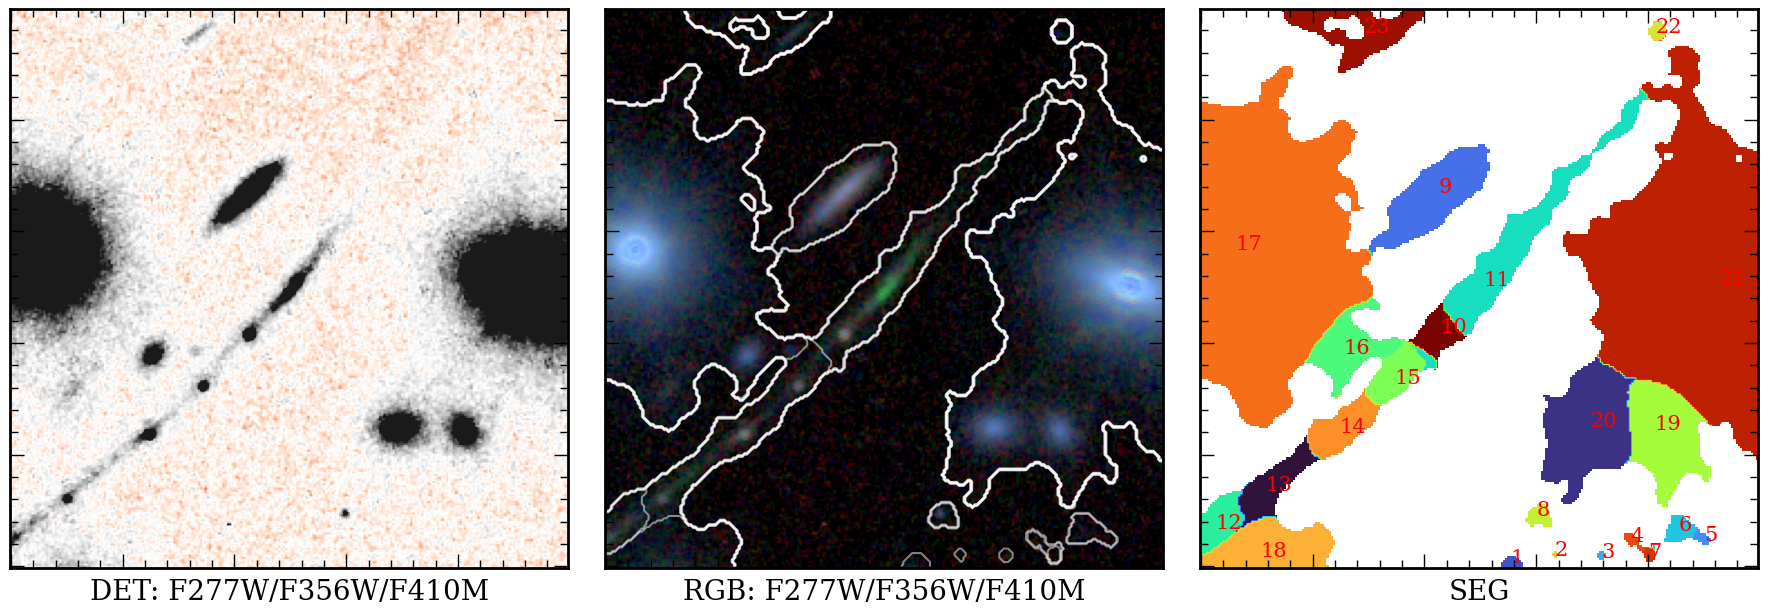

In [7]:
# Examine the quality of the segments

fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot(131)

scl = np.percentile(cut_data.data,q=[50,84])
sigma = scl[1]-scl[0]

ax.imshow(cut_data.data,origin='lower',vmin = scl[0]-3*sigma, vmax = scl[0]+3*sigma,cmap='RdGy')


ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel('DET: F277W/F356W/F410M')
ax = fig.add_subplot(132)
ax.imshow(col_image,origin='lower')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel('RGB: F277W/F356W/F410M')
ax.contour(seg_map,colors='white', alpha=0.5)

ax = fig.add_subplot(133)
    
_ , seg = grizli.catalog.randomize_segmentation_labels(seg_map)
ax.imshow(seg,origin='lower',cmap='turbo')
#ax.plot(tab['x'],tab['y'],marker='x',lw=0,ms=10,color='red')

for i,_ in enumerate(tab):
    ax.text(tab['x'][i],tab['y'][i],tab['number'][i],color='r',fontsize=15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('SEG')

plt.tight_layout()
#plt.savefig(f'segmentation/{NAME}_smooth.pdf',bbox_inches='tight')

In [56]:
# Save segmentation images if necessary

if False:
    seg_save= fits.HDUList()
    seg_save.append(fits.ImageHDU())
    seg_save[0].data = seg_map
    seg_save[0].header.update(wcs.to_header())
    seg_save.writeto(f'segmentation/{NAME}_seg_smooth.fits', overwrite=True)

In [192]:
#Now if we have seg map that we are happy with we can start extracting iso fluxes



import fnmatch
files = os.listdir('psf_matched')

# Find all the available mosaics in the directory

root = 'sunrise-grizli-v4.0'
filtered = fnmatch.filter(files, f'{root}-f**_sci_conv.fits')

filters = []
for i in filtered:
    fname = i[len(root)+1:len(root)+6]
    if 'clear' in i:
        fname+='-clear'
    if 'drz' in i:
        fname+='_drz'
    if 'drc' in i:
        fname+='_drc'
    filters.append(fname)


In [193]:
filters

['f277w-clear_drc',
 'f110w_drz',
 'f410m-clear_drc',
 'f160w_drz',
 'f140w_drz',
 'f356w-clear_drc',
 'f125w_drz',
 'f150w-clear_drc',
 'f444w-clear_drc',
 'f105w_drz',
 'f606w_drc',
 'f200w-clear_drc',
 'f090w-clear_drc',
 'f115w-clear_drc',
 'f475w_drc',
 'f814w_drc',
 'f435w_drc']

In [196]:
# Extract the photometry and errors within each segment
# For SW filters, the segmentation map is rescaled by a factor of two

phot = tab.copy()
phot['id'] = tab['number']
phot['ZSPEC'] = [6.2]

for i, flt in enumerate(filters):
    
    data_, err_, bkg_data_, wcs_,pixel_scale_ = prep_grz(root,flt,psf_matched=True)
    
    data_bkg_ = data_ - bkg_data_
    
    #Cut

    
    data_cut = Cutout2D(data_,position=pos,size=size,wcs=wcs_).data
    data_bkg_cut = Cutout2D(data_bkg_,position=pos,size=size,wcs=wcs_).data
    err_cut = Cutout2D(err_,position=pos,size=size,wcs=wcs_).data
    
    # Compute the background within cutouts instead
    
    bkg_cut = True
    if bkg_cut:
        bkg_temp = comp_background(data_cut,err_cut,pixel_scale=pixel_scale_)
        data_bkg_cut = data_cut - bkg_temp
    
        
    
    
    if data_bkg_cut.shape!=seg_map.shape:
        ratio = data_bkg_cut.shape[0]/seg_map.shape[0]
        
        print(f'Mismatch between seg map and sci image. Oversampling by {ratio}')
        
        
        seg_map_ = np.int_(resize(seg_map,data_bkg_cut.shape,preserve_range=True))
        
        sw = True
        assert data_bkg_cut.shape==seg_map_.shape, 'Seg map dimension mismatch'
        
    else:
        sw = False
        seg_map_ = seg_map
    
    
    iso_flux, iso_fluxerr, iso_area = prep.get_seg_iso_flux(data_bkg_cut, seg_map_, phot,
                                                 err=err_cut, verbose=1)
    
    if sw:
        iso_flux = []
        iso_fluxerr = []
        iso_area = []
        
        for idd in phot['id']:
            iso_flux.append(data_bkg_cut[seg_map_==idd].sum())
            iso_fluxerr.append(np.sqrt((err_cut[seg_map_==idd]**2).sum()))
            iso_area.append(np.sum(seg_map_==idd))
            
        iso_flux = np.array(iso_flux)
        iso_fluxerr = np.array(iso_fluxerr)
        iso_area = np.array(iso_area)
    
    colnames = [flt[:5]+'_flux_iso',flt[:5]+'_fluxerr_iso',flt[:5]+'_area_iso']
    
    to_uJy = (10*u.nJy).to(u.uJy)
    phot[colnames[0]] = iso_flux*to_uJy
    phot[colnames[1]] = iso_fluxerr*to_uJy
    phot[colnames[2]] = iso_area
    


Loaded f277w-clear_drc image as psf_matched/sunrise-grizli-v4.0-f277w-clear_drc_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:07:02,890 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f110w_drz image as psf_matched/sunrise-grizli-v4.0-f110w_drz_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:07:07,611 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f410m-clear_drc image as psf_matched/sunrise-grizli-v4.0-f410m-clear_drc_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:07:12,250 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f160w_drz image as psf_matched/sunrise-grizli-v4.0-f160w_drz_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:07:16,965 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f140w_drz image as psf_matched/sunrise-grizli-v4.0-f140w_drz_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:07:21,909 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f356w-clear_drc image as psf_matched/sunrise-grizli-v4.0-f356w-clear_drc_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:07:26,707 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f125w_drz image as psf_matched/sunrise-grizli-v4.0-f125w_drz_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:07:31,420 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f150w-clear_drc image as psf_matched/sunrise-grizli-v4.0-f150w-clear_drc_sci_conv.fits
Detected pixel scale of 0.02"/pix


2022-11-03 16:07:54,072 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Mismatch between seg map and sci image. Oversampling by 2.0
Loaded f444w-clear_drc image as psf_matched/sunrise-grizli-v4.0-f444w-clear_drc_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:08:14,319 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f105w_drz image as psf_matched/sunrise-grizli-v4.0-f105w_drz_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:08:19,757 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f606w_drc image as psf_matched/sunrise-grizli-v4.0-f606w_drc_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:08:24,348 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f200w-clear_drc image as psf_matched/sunrise-grizli-v4.0-f200w-clear_drc_sci_conv.fits
Detected pixel scale of 0.02"/pix


2022-11-03 16:08:43,622 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Mismatch between seg map and sci image. Oversampling by 2.0
Loaded f090w-clear_drc image as psf_matched/sunrise-grizli-v4.0-f090w-clear_drc_sci_conv.fits
Detected pixel scale of 0.02"/pix


2022-11-03 16:09:22,449 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Mismatch between seg map and sci image. Oversampling by 2.0
Loaded f115w-clear_drc image as psf_matched/sunrise-grizli-v4.0-f115w-clear_drc_sci_conv.fits
Detected pixel scale of 0.02"/pix


2022-11-03 16:09:56,999 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Mismatch between seg map and sci image. Oversampling by 2.0
Loaded f475w_drc image as psf_matched/sunrise-grizli-v4.0-f475w_drc_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:10:16,219 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f814w_drc image as psf_matched/sunrise-grizli-v4.0-f814w_drc_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:10:22,116 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



Loaded f435w_drc image as psf_matched/sunrise-grizli-v4.0-f435w_drc_sci_conv.fits
Detected pixel scale of 0.04"/pix


2022-11-03 16:10:27,235 - stpipe - WARNING - /var/folders/tb/vgq1p9q95ldf2x3wl709jm400000gn/T/ipykernel_6872/604854273.py:23: RuntimeWarning: divide by zero encountered in divide
  err = 1/np.sqrt(wht)



In [197]:
phot

thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,x_image,y_image,number,ra,dec,x_world,y_world,id,ZSPEC,f277w_flux_iso,f277w_fluxerr_iso,f277w_area_iso,f110w_flux_iso,f110w_fluxerr_iso,f110w_area_iso,f410m_flux_iso,f410m_fluxerr_iso,f410m_area_iso,f160w_flux_iso,f160w_fluxerr_iso,f160w_area_iso,f140w_flux_iso,f140w_fluxerr_iso,f140w_area_iso,f356w_flux_iso,f356w_fluxerr_iso,f356w_area_iso,f125w_flux_iso,f125w_fluxerr_iso,f125w_area_iso,f150w_flux_iso,f150w_fluxerr_iso,f150w_area_iso,f444w_flux_iso,f444w_fluxerr_iso,f444w_area_iso,f105w_flux_iso,f105w_fluxerr_iso,f105w_area_iso,f606w_flux_iso,f606w_fluxerr_iso,f606w_area_iso,f200w_flux_iso,f200w_fluxerr_iso,f200w_area_iso,f090w_flux_iso,f090w_fluxerr_iso,f090w_area_iso,f115w_flux_iso,f115w_fluxerr_iso,f115w_area_iso,f475w_flux_iso,f475w_fluxerr_iso,f475w_area_iso,f814w_flux_iso,f814w_fluxerr_iso,f814w_area_iso,f435w_flux_iso,f435w_fluxerr_iso,f435w_area_iso
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,,uJy,uJy,
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,int32,float64,float64,float64,float64,int32,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float32,float32,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float32,float32,int64,float32,float32,int64,float32,float32,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64
0.00010856946755666286,320,290,94,119,89,119,107.31040672123972,104.98145357996084,14.501838919609725,12.83240087184754,3.6772859683270553,0.0013227180892148149,0.0012823976464913132,0.00012754096786919117,4.175877571105957,3.145836353302002,0.6737927794456482,0.07436013221740723,0.08403405547142029,-0.042617663741111755,0.29515790939331055,0.30026599764823914,0.006070271600037813,0.009419301524758339,107,105,107,104,1,108.31040672123972,105.98145357996084,10,24.346621963388763,-8.46425011685403,24.346621963388763,-8.46425011685403,10,6.2,0.16031570434570314,0.004846166670322418,332,0.12690583229064942,0.005757060050964356,332,0.17757057189941405,0.008117132186889649,332,0.05726409435272217,0.029097986221313477,332,0.11781393051147461,0.0424000883102417,332,0.17618377685546877,0.004466574788093567,332,0.12358114242553711,0.04875265598297119,332,0.1103166,0.008311309,1726,0.18195510864257813,0.006559048891067505,332,0.17829315185546876,0.028641185760498046,332,0.012753955125808717,0.013135641813278198,332,0.14279976,0.0068082195,1726,0.091270484,0.01009017,1726,0.09453288,0.010189599,1726,0.0002538847923278809,0.011052415370941163,332,0.026291542053222657,0.008289093971252442,332,-0.05485567569732666,0.02136267185211182,332
0.00010856946755666286,1649,1394,94,197,86,211,126.41452362444917,125.92682306232437,318.15225759703526,486.97432534843165,381.35532459297474,0.019042662688907218,0.02907311018897094,0.022938622729801482,28.162899017333984,3.460880994796753,0.8943145275115967,0.051259931176900864,0.03348936885595322,-0.08028450608253479,0.8854166269302368,0.9115142226219177,0.0036150699015706778,0.004840124398469925,125,124,124,122,1,127.41452362444917,126.92682306232437,11,24.346407363114103,-8.464017385905498,24.346407363114103,-8.464017385905498,11,6.2,0.3857255554199219,0.010342541933059692,1611,0.2769698715209961,0.012646417617797851,1611,0.3749703598022461,0.017246049642562867,1611,0.23858274459838869,0.06328869342803956,1611,0.11215541839599609,0.09159685134887695,1611,0.5911727142333985,0.009417314529418946,1611,0.2794770050048828,0.1067429256439209,1611,0.20648009,0.0155041